# Predicting Bike Sharing Demand with AutoGluon

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor
from autogluon.common import space
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle.api.kaggle_api_extended import KaggleApi

%matplotlib inline

## Download Data from Kaggle
Make use of the Kaggle API to download data files for the project. The Kaggle community will use either hosted notebooks or the CLI commands within a notebook to accomplish API related tasks. I prefer to use the API directly.

In [11]:
def get_competition_data(competition):
    '''
    uses the Kaggle API to download competition files
    '''
    # instantiate and authenticate 
    api = KaggleApi()
    api.authenticate()

    # check if we already downloaded
    if len(os.listdir('../data')) == 0:
        api.competition_download_files(competition, path='../data')

        # unzip file
        with zipfile.ZipFile('../data/bike-sharing-demand.zip', 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname('../data/bike-sharing-demand.zip'))

        os.remove('../data/bike-sharing-demand.zip')
    else:
        print(f'files for {competition} already downloaded.')

get_competition_data('bike-sharing-demand')

In [19]:
# read in data files to respective dataframes
train = pd.read_csv('../data/raw/train.csv', parse_dates=['datetime'])
test = pd.read_csv('../data/raw/test.csv', parse_dates=['datetime'])
submission = pd.read_csv('../data/raw/sampleSubmission.csv', parse_dates=['datetime'])

In [101]:
# preview the shape of our data
data = {
    'train': train.shape,
    'test': test.shape,
    'submission': submission.shape
}

data

{'train': (10886, 12), 'test': (6493, 9), 'submission': (6493, 2)}

- Looks like there a 3 less columns in our testing set as compared to our training set. the dependent variavle is a given, but we will need to consider the missing columns when we train our model.

In [18]:
# confirm feature diff
train.columns.difference(test.columns)

Index(['casual', 'count', 'registered'], dtype='object')

In [19]:
# check dataframe info for dtypes and nulls
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


- no nulls detected. there are a few columns that would benefit from being converted to categorical.

In [52]:
# preview summary statistics
train.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,10886,2011-12-27 05:56:22.399411968,2011-01-01 00:00:00,2011-07-02 07:15:00,2012-01-01 20:30:00,2012-07-01 12:45:00,2012-12-19 23:00:00,NaN
season,10886.0,2.506614,1.0,2.0,3.0,4.0,4.0,1.116174
holiday,10886.0,0.028569,0.0,0.0,0.0,0.0,1.0,0.166599
workingday,10886.0,0.680875,0.0,0.0,1.0,1.0,1.0,0.466159
weather,10886.0,1.418427,1.0,1.0,1.0,2.0,4.0,0.633839
temp,10886.0,20.23086,0.82,13.94,20.5,26.24,41.0,7.79159
atemp,10886.0,23.655084,0.76,16.665,24.24,31.06,45.455,8.474601
humidity,10886.0,61.88646,0.0,47.0,62.0,77.0,100.0,19.245033
windspeed,10886.0,12.799395,0.0,7.0015,12.998,16.9979,56.9969,8.164537
casual,10886.0,36.021955,0.0,4.0,17.0,49.0,367.0,49.960477


## Train a model using AutoGluon's Tabular Prediction
Requirements:
- We are prediting `count`, so it is the label we are setting.
- Ignore `casual` and `registered` columns as they are also not present in the test dataset.
- Use the `root_mean_squared_error` as the metric to use for evaluation.
- Set a time limit of 10 minutes (600 seconds).
- Use the preset `best_quality` to focus on creating the best model.

In [22]:
# train model using AutoGluon's Tabular predictor
predictor = TabularPredictor(
    label='count',
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    learner_kwargs={
        'ignored_columns': ['casual', 'registered']
    }
).fit(
    train_data=train,
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240314_205250"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240314_205250/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 150s
AutoGluon will save models to "AutogluonModels/ag-20240314_205250/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0

### Review AutoGluon's training run with ranking of models that did the best.

In [23]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -50.672962  root_mean_squared_error       1.602244  393.373122                0.000187           0.210506            3       True         17
1   NeuralNetFastAI_BAG_L2  -51.801156  root_mean_squared_error       1.048827  385.775174                0.134645          88.492185            2       True         14
2   RandomForestMSE_BAG_L2  -53.230802  root_mean_squared_error       1.192769  303.122845                0.278587           5.839857            2       True         11
3     ExtraTreesMSE_BAG_L2  -53.542762  root_mean_squared_error       1.188825  298.830573                0.274643           1.547585            2       True         13
4           XGBoost_BAG_L2  -54.843269  root_mean_squared_error       0.935117  303.195496   

/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'mod

In [24]:
# print leaderboard
leaderboard = predictor.leaderboard()
leaderboard.sort_values(by='score_val', ascending=False)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-50.672962,root_mean_squared_error,1.602244,393.373122,0.000187,0.210506,3,True,17
1,NeuralNetFastAI_BAG_L2,-51.801156,root_mean_squared_error,1.048827,385.775174,0.134645,88.492185,2,True,14
2,RandomForestMSE_BAG_L2,-53.230802,root_mean_squared_error,1.192769,303.122845,0.278587,5.839857,2,True,11
3,ExtraTreesMSE_BAG_L2,-53.542762,root_mean_squared_error,1.188825,298.830573,0.274643,1.547585,2,True,13
4,XGBoost_BAG_L2,-54.843269,root_mean_squared_error,0.935117,303.195496,0.020935,5.912508,2,True,15
5,CatBoost_BAG_L2,-55.388259,root_mean_squared_error,0.933260,326.213589,0.019078,28.930601,2,True,12
6,KNeighborsDist_BAG_L1,-84.146423,root_mean_squared_error,0.017272,0.006830,0.017272,0.006830,1,True,2
7,WeightedEnsemble_L2,-84.146423,root_mean_squared_error,0.017459,0.172469,0.000187,0.165639,2,True,10
8,NeuralNetTorch_BAG_L2,-96.288177,root_mean_squared_error,1.149109,313.022136,0.234926,15.739148,2,True,16
9,KNeighborsUnif_BAG_L1,-101.588176,root_mean_squared_error,0.014761,0.007998,0.014761,0.007998,1,True,1


Based on our inital training on the raw data, the `WeightedEnsemble_L3` appears to return the best score value for RMSE with 50.672962.

### Create Predictions from test dataset

In [25]:
# create predictions from test set
predictions = predictor.predict(test)
predictions.head()

0    28.426010
1    42.168674
2    46.493607
3    49.792675
4    52.344673
Name: count, dtype: float32

In [26]:
# check for negative values in predictions
predictions.describe()

count    6493.000000
mean      100.191551
std        87.848969
min         2.558878
25%        21.488991
50%        66.787315
75%       168.489502
max       352.200165
Name: count, dtype: float64

Kaggle will reject our submission if it contains prediction values less than zero, so we need to identify and replace all negative values with `0`.

In [28]:
def negative_to_zero(data: pd.DataFrame):
    '''converts negative values to zero'''
    if len(data[data < 0]) > 0:
        data[data < 0] = 0

    return data

predictions = negative_to_zero(predictions)



### Set predictions to submission dataframe, save, and submit.

In [29]:
# generate submissions file
submission["count"] = predictions
submission.to_csv("../data/submissions/submission.csv", index=False)

In [30]:
# instantiate and authenticate 
api = KaggleApi()
api.authenticate()

# submit to competition
api.competition_submit(
    '../data/submissions/submission.csv', 
    message='raw submission 2024-03-14', 
    competition='bike-sharing-demand'
)

100%|██████████| 188k/188k [00:02<00:00, 90.2kB/s]


Successfully submitted to Bike Sharing Demand

In [34]:
# get submission result
# could not find a better version via the api
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                   date                 description                                  status    publicScore  privateScore  
-------------------------  -------------------  -------------------------------------------  --------  -----------  ------------  
submission.csv             2024-03-14 22:14:36  raw submission 2024-03-14                    complete  1.77468      1.77468       
submission_hpo.csv         2024-03-11 20:51:03  submission with optimized hyperparameters    complete  1.29778      1.29778       
submission_dt_feature.csv  2024-03-11 20:11:15  submission with engineered datetime feature  complete  0.56875      0.56875       


our inital model scored `1.77468` based on Kaggle's ranking system

## Exploratory Analysis and Feature Engineering
Use exploratory data analysis techniques to determine which feature(s) could help to improve our model. The recommendation is to convert the `datetime` field into `hour`, `day`, and `month` parts. 

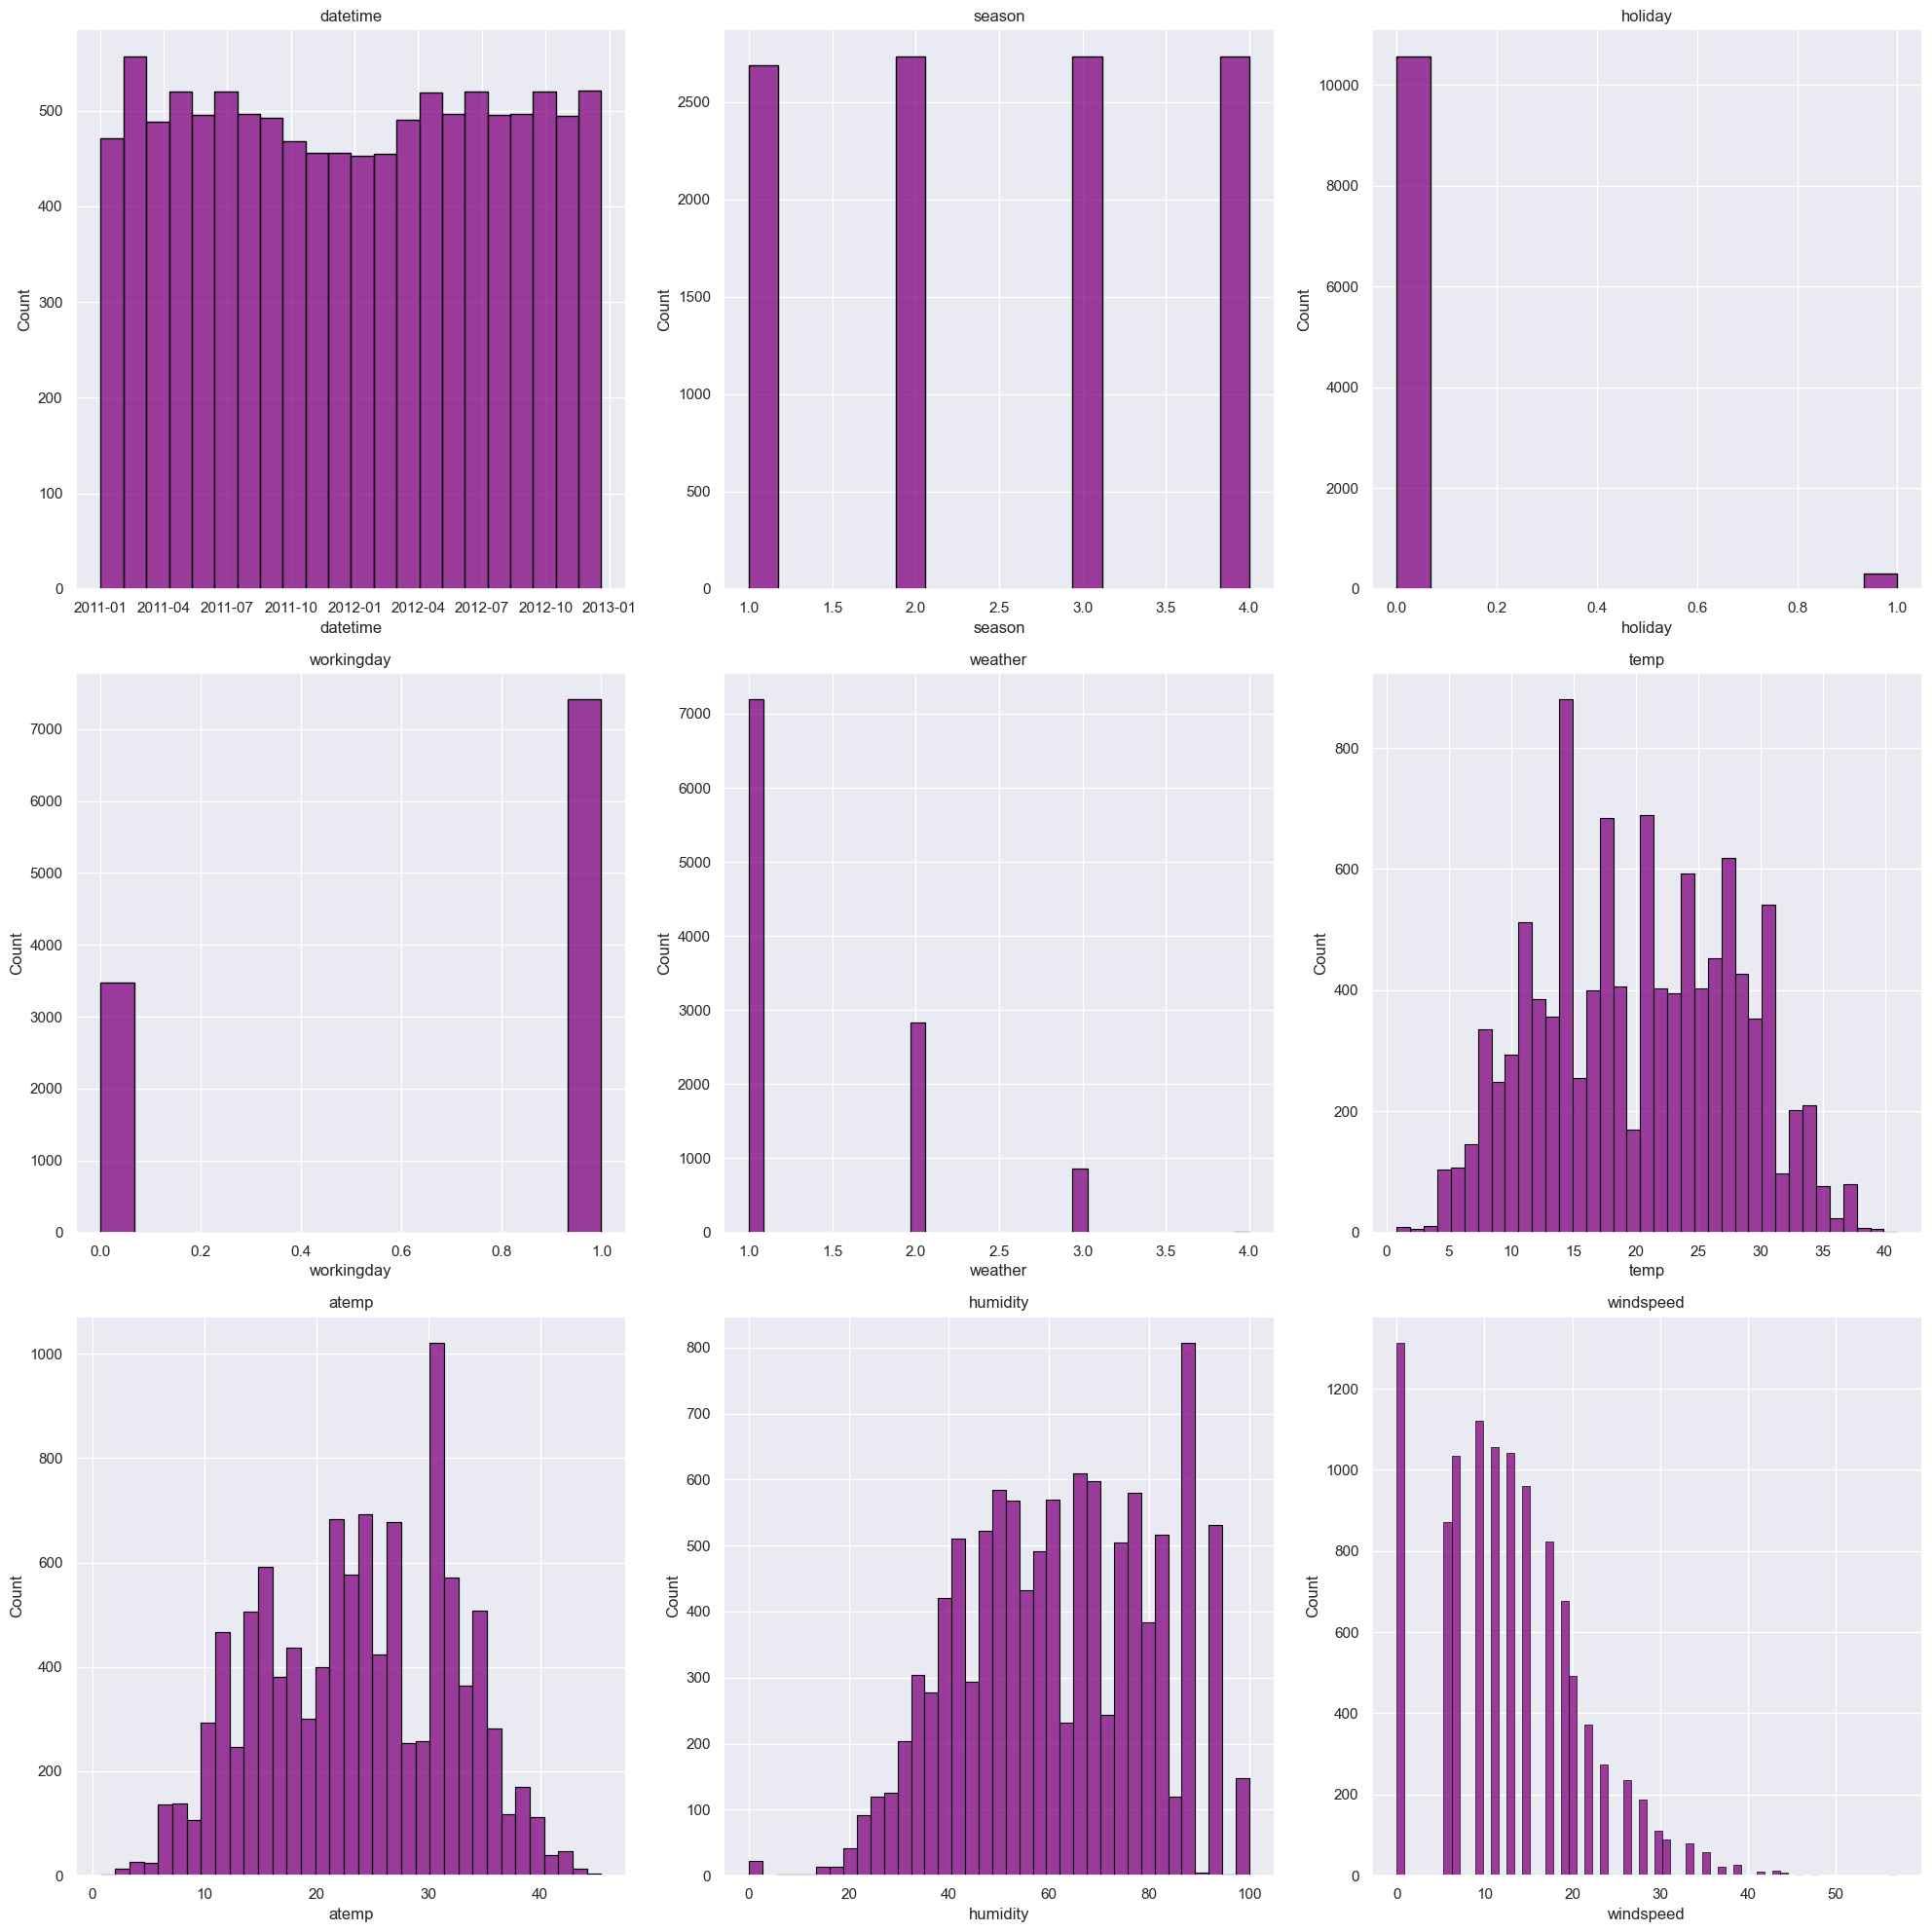

In [53]:
# eda
# select columns
# drop unused features
train_eda = train [['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']]

fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical column and plot histogram
for i, col in enumerate(train_eda.columns):
    sns.histplot(data=train_eda, x=col, ax=axes[i], color='#d891ef', edgecolor='black')
    axes[i].set_title(col)  # Set title as column name

# Adjust layout
plt.tight_layout()
plt.show()

**Observations**
- season and weather are categorical
- humidity is slightly left skewed
- windspeed is right skewed

In [20]:
# add time features to train
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['day_of_week'] = train['datetime'].dt.day_of_week
train['is_weekday'] = (train['datetime'].dt.day_of_week < 5).astype(int)

# add time features to test
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['day_of_week'] = test['datetime'].dt.day_of_week
test['is_weekday'] = (test['datetime'].dt.day_of_week < 5).astype(int)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     10886 non-null  datetime64[ns]
 1   season       10886 non-null  int64         
 2   holiday      10886 non-null  int64         
 3   workingday   10886 non-null  int64         
 4   weather      10886 non-null  int64         
 5   temp         10886 non-null  float64       
 6   atemp        10886 non-null  float64       
 7   humidity     10886 non-null  int64         
 8   windspeed    10886 non-null  float64       
 9   casual       10886 non-null  int64         
 10  registered   10886 non-null  int64         
 11  count        10886 non-null  int64         
 12  month        10886 non-null  int32         
 13  day          10886 non-null  int32         
 14  hour         10886 non-null  int32         
 15  day_of_week  10886 non-null  int32         
 16  is_w

In [22]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     6493 non-null   datetime64[ns]
 1   season       6493 non-null   int64         
 2   holiday      6493 non-null   int64         
 3   workingday   6493 non-null   int64         
 4   weather      6493 non-null   int64         
 5   temp         6493 non-null   float64       
 6   atemp        6493 non-null   float64       
 7   humidity     6493 non-null   int64         
 8   windspeed    6493 non-null   float64       
 9   month        6493 non-null   int32         
 10  day          6493 non-null   int32         
 11  hour         6493 non-null   int32         
 12  day_of_week  6493 non-null   int32         
 13  is_weekday   6493 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(6)
memory usage: 608.8 KB


Check to see if hours in a day impact the demand for bike sharing

<Axes: xlabel='hour', ylabel='count'>

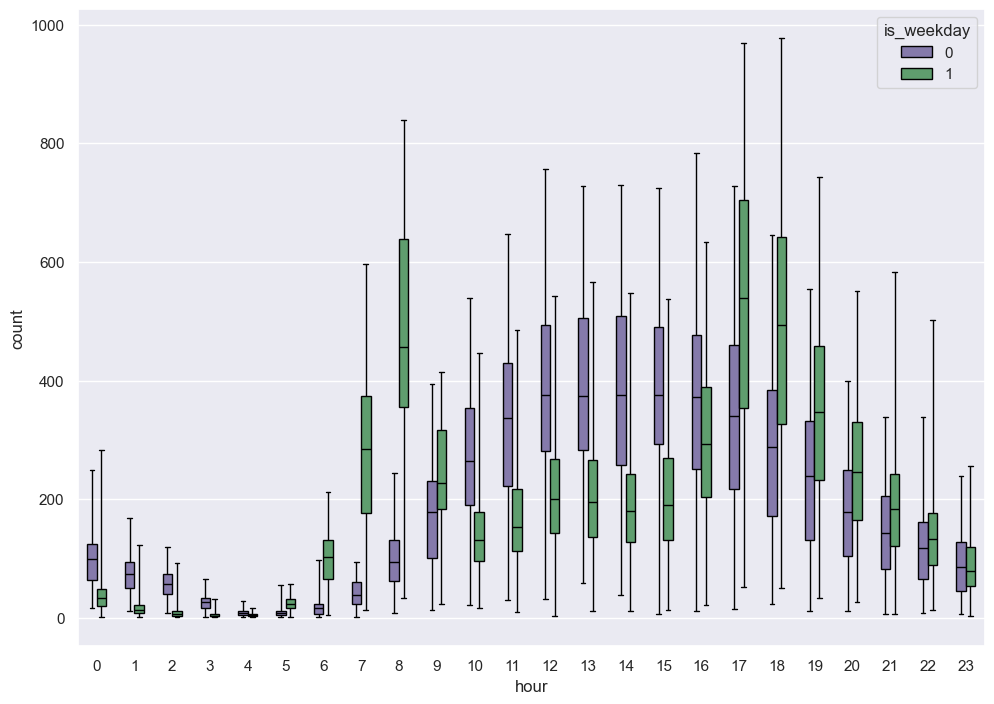

In [15]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='hour', y='count', data=train, hue='is_weekday', palette=['m','g'], linecolor='black', whis=(0,100), width=0.5)

<Axes: xlabel='day_of_week', ylabel='count'>

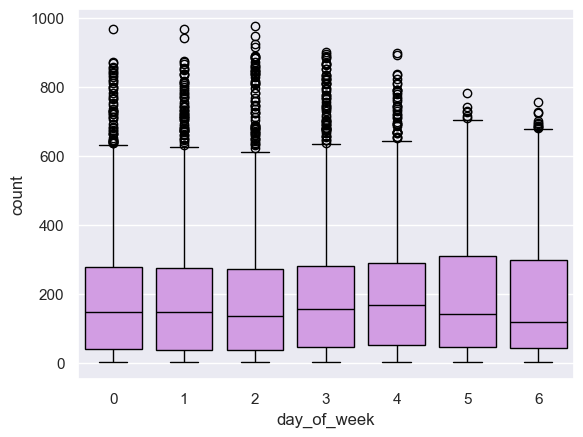

In [8]:
sns.boxplot(x='day_of_week', y='count', data=train, color='#d891ef', linecolor='black')

As observed in the figure above, the demand for bike sharing appears to peak around 8am and then again between 5-7pm. These are typically hours we see people commuting to and from work respectively. We can create a categorical feature called `demand` that bins our data into these categories

In [ ]:
# classify demand
def categorize_demand(df: pd.DataFrame) -> pd.DataFrame:
    """
    categorize demand based on day of week and time of day
    """
    conditions = [
        (df["hour"] <= 6),  # 0
        (df["hour"] > 6) & (df["hour"] <= 9) & (df["is_weekday"] == 1),  # 3
        (df["hour"] > 6) & (df["hour"] <= 9) & (df["is_weekday"] == 0),  # 1
        (df["hour"] > 9) & (df["hour"] <= 15) & (df["is_weekday"] == 1),  # 1,
        (df["hour"] > 9) & (df["hour"] <= 15) & (df["is_weekday"] == 0),  # 2,
        (df["hour"] > 15) & (df["hour"] <= 19) & (df["is_weekday"] == 1),  # 3
        (df["hour"] > 15) & (df["hour"] <= 19) & (df["is_weekday"] == 0),  # 1
        (df["hour"] > 19) & (df["hour"] <= 21) & (df["is_weekday"] == 1),  # 2 ,
        (df["hour"] > 19) & (df["hour"] <= 21) & (df["is_weekday"] == 0),  # 1 ,
        (df["hour"] > 21),  # 1
    ]
    # create a list of the values we want to assign for each condition
    values = [0, 3, 1, 1, 2, 3, 1, 2, 1, 1]

    # create a new column and use np.select to assign values to it using our lists as arguments
    df["demand"] = np.select(conditions, values)

    return df

array([[<Axes: title={'center': 'demand'}>]], dtype=object)

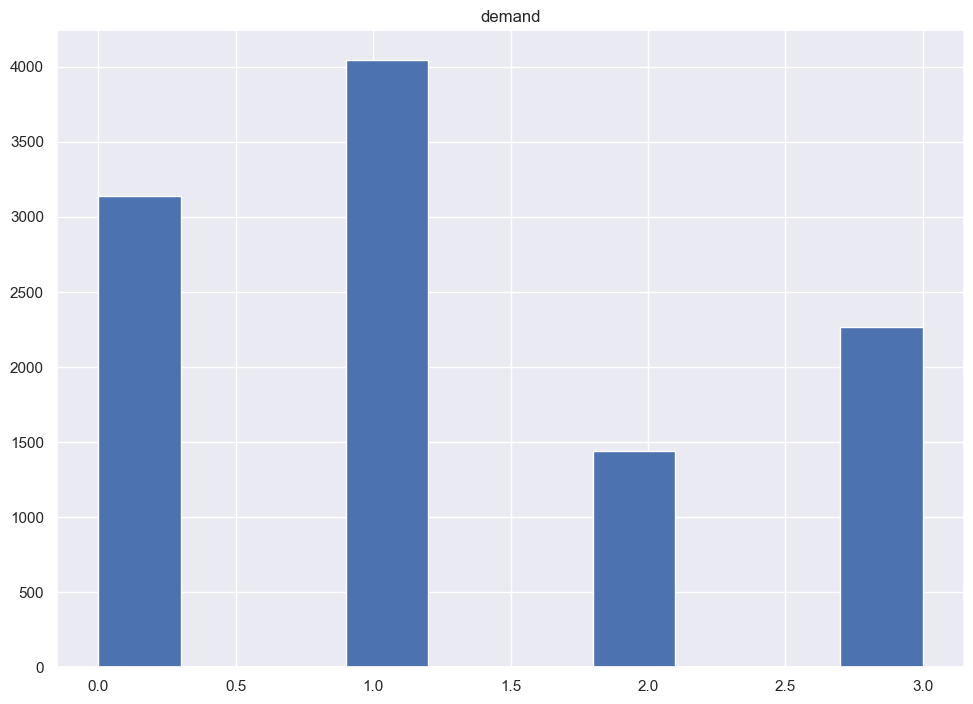

In [24]:
train = categorize_demand(train)

# display updated DataFrame
train.hist('demand')

In [18]:
test = categorize_demand(test)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6493,) and arg 1 with shape (10886,).

In [105]:
# convert categorical columns
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
train["demand"] = train["demand"].astype('category')

# do the same for the test set
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')
test["demand"] = test["demand"].astype('category')

## Rerun the model with the same settings as before, just with more features

In [80]:
# rerun the model with new features
predictor_new_features = TabularPredictor(
    label='count',
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    learner_kwargs={
        'ignored_columns': ['casual', 'registered']
    }
).fit(
    train_data=train,
    time_limit=600,
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240314_235826"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240314_235826/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 150s
AutoGluon will save models to "AutogluonModels/ag-20240314_235826/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0

In [81]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -29.878025  root_mean_squared_error       1.226299  437.799646                0.000308           0.245799            3       True         14
1          CatBoost_BAG_L2  -30.429080  root_mean_squared_error       0.903866  371.644163                0.030678          73.933249            2       True         10
2   NeuralNetFastAI_BAG_L2  -30.609037  root_mean_squared_error       1.147944  359.072092                0.274756          61.361178            2       True         12
3           XGBoost_BAG_L2  -30.895341  root_mean_squared_error       0.920557  302.259420                0.047369           4.548506            2       True         13
4     ExtraTreesMSE_BAG_L2  -31.676180  root_mean_squared_error       1.159386  299.388815   

/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.58817625927213,
  'KNeighborsDist_BAG_L1': -84.14642264302962,
  'RandomForestMSE_BAG_L1': -38.707154232479205,
  'CatBoost_BAG_L1': -33.33643652989511,
  'E

In [82]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    14.202793
1    10.465942
2     9.100179
3     8.743116
4     7.848915
Name: count, dtype: float32

In [83]:
# convert negatives to zeros
predictions_new_features = negative_to_zero(predictions_new_features)

In [84]:
submission_new_features = pd.read_csv('../data/raw/sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("../data/submissions/submission_new_features.csv", index=False)

In [85]:
# submit to competition
api.competition_submit(
    '../data/submissions/submission_new_features.csv', 
    message='feature engineering 2024-03-14', 
    competition='bike-sharing-demand'
)

100%|██████████| 188k/188k [00:01<00:00, 101kB/s]


Successfully submitted to Bike Sharing Demand

In [86]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

15136.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                     date                 description                                  status    publicScore  privateScore  
---------------------------  -------------------  -------------------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-03-15 00:17:48  feature engineering 2024-03-14               complete  0.74802      0.74802       
submission.csv               2024-03-14 22:14:36  raw submission 2024-03-14                    complete  1.77468      1.77468       
submission_hpo.csv           2024-03-11 20:51:03  submission with optimized hyperparameters    complete  1.29778      1.29778       


our model with engineered features scored `0.74802`

## Hyperparameter Optimization

- There are many options for hyper parameter optimization.
- Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
- The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.


In [106]:
# split training data into training and validation sets
train_df = train.loc[train['datetime'].dt.day < 17]
validation_df = train.loc[train['datetime'].dt.day >= 17]
train_df.shape, validation_df.shape

((9174, 16), (1712, 16))

In [116]:
time_limit = 30*60
num_trials = 10
search_strategy = 'auto'

hyperparameter_tune_kwargs = { 
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

# Non-default hyperparameter values for neural network models
nn_options = {  
    'num_epochs': 30,  # number of training epochs (controls training time of NN models)
    'learning_rate': space.Real(1e-5, 1e-1, default=1e-3, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': space.Categorical('relu', 'softrelu', 'sigmoid','tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = {  # hyperparameters of each model type
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained


In [117]:
predictor_hpo = TabularPredictor(
    label='count',
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    learner_kwargs={
        'ignored_columns': ['casual', 'registered']
    }
).fit(
    train_data=train,
    time_limit=time_limit,
    presets='best_quality',
    auto_stack=True, 
    num_bag_folds=5, 
    num_bag_sets=5, 
    num_stack_levels=2,
    hyperparameters=hyperparameters, 
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240315_140903"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=5, num_bag_sets=5
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 1800 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240315_140903/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 450s
AutoGluon will save models to "AutogluonModels/ag-20240315_140903/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Must install dask-expr to activate query planning.
Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/dask/dataframe/__init__.py", line 22, in _dask_expr_enabled
    import dask_expr  # noqa: F401
ModuleNotFoundError: No module named 'dask_expr'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abst

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 5)
	Ran out of time, stopping training early. (Stopping on epoch 5)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 9)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1/T1 ...
	-68.1621	 = Validation score   (-root_mean_squared_error)
	36.11s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1/T2 ...
	-74.1479	 = Validation score   (-root_mean_squared_error)
	45.5s	 = Training   runtime
	0.0s	 = Validation runtime
Repeating k-fold bagging: 2/5
Fitting model: NeuralNetTorch_BAG_L1/T1 ... Training model for up to 117.9s of the 367.73s of remaining time.
	Fitting 5 child models (S2F1 - S2F5) | Fitting with SequentialLoc

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Must install dask-expr to activate query planning.
Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/dask/dataframe/__init__.py", line 22, in _dask_expr_enabled
    import dask_expr  # noqa: F401
ModuleNotFoundError: No module named 'dask_expr'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abst

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2/T1 ...
	-68.2688	 = Validation score   (-root_mean_squared_error)
	46.77s	 = Training   runtime
	0.0s	 = Validation runtime
Repeating k-fold bagging: 2/5
Fitting model: NeuralNetTorch_BAG_L2/T1 ... Training model for up to 122.04s of the 206.66s of remaining time.
	Fitting 5 child models (S2F1 - S2F5) | Fitting with SequentialLocalFoldFittingStrategy
	-67.961	 = Validation score   (-root_mean_squared_error)
	112.55s	 = Training   runtime
	0.12s	 = Validation runtime
Completed 2/5 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 140.74s of remaining time.
	Ensemble Weights: {'NeuralNetTorch_BAG_L2/T1': 1.0}
	-67.961	 = Validation score   (-root_mean_squared_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 2 L3 models ...
Hyperparameter tuning model: 

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Must install dask-expr to activate query planning.
Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/dask/dataframe/__init__.py", line 22, in _dask_expr_enabled
    import dask_expr  # noqa: F401
ModuleNotFoundError: No module named 'dask_expr'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abst

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 21)
	Ran out of time, stopping training early. (Stopping on epoch 18)
	Ran out of time, stopping training early. (Stopping on epoch 22)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L3/T1 ...
	-70.3961	 = Validation score   (-root_mean_squared_error)
	49.68s	 = Training   runtime
	0.0s	 = Validation runtime
Repeating k-fold bagging: 2/5
Fitting model: NeuralNetTorch_BAG_L3/T1 ... Training model for up to 90.78s of the 90.77s of remaining time.
	Fitting 5 child models (S2F1 - S2F5) | Fitting with SequentialLocalFoldFittingStrategy
	-69.8321	 = Validation score   (-root_mean_squared_error)
	110.71s	 = Training   runtime
	0.12s	 = Validation runtime
Completed 2/5 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L4 ... Training model for up to 360.0s of the 29.59s of remaining time.
	Ensemble Weights: {'Neu

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Must install dask-expr to activate query planning.
Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/dask/dataframe/__init__.py", line 22, in _dask_expr_enabled
    import dask_expr  # noqa: F401
ModuleNotFoundError: No module named 'dask_expr'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abst

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 17)
	Ran out of time, stopping training early. (Stopping on epoch 17)
	Ran out of time, stopping training early. (Stopping on epoch 18)
	Ran out of time, stopping training early. (Stopping on epoch 21)
	Ran out of time, stopping training early. (Stopping on epoch 24)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1/T1 ...
	-65.1715	 = Validation score   (-root_mean_squared_error)
	75.26s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1/T2 ...
	-68.1052	 = Validation score   (-root_mean_squared_error)
	183.03s	 = Training   runtime
	0.0s	 = Validation runtime
Repeating k-fold bagging: 2/5
Fitting model: NeuralNetTorch_BAG_L1/T1 ... Training model for up to 353.96s of the 1120.0s of remaining

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Must install dask-expr to activate query planning.
Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/dask/dataframe/__init__.py", line 22, in _dask_expr_enabled
    import dask_expr  # noqa: F401
ModuleNotFoundError: No module named 'dask_expr'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abst

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 15)
	Ran out of time, stopping training early. (Stopping on epoch 16)
	Ran out of time, stopping training early. (Stopping on epoch 17)
	Ran out of time, stopping training early. (Stopping on epoch 19)
	Ran out of time, stopping training early. (Stopping on epoch 25)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2/T1 ...
	-60.9291	 = Validation score   (-root_mean_squared_error)
	66.07s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L2/T2 ...
	-60.4738	 = Validation score   (-root_mean_squared_error)
	157.16s	 = Training   runtime
	0.0s	 = Validation runtime
Repeating k-fold bagging: 2/5
Fitting model: NeuralNetTorch_BAG_L2/T1 ... Training model for up to 310.38s of the 577.52s of remaining

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
Must install dask-expr to activate query planning.
Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/dask/dataframe/__init__.py", line 22, in _dask_expr_enabled
    import dask_expr  # noqa: F401
ModuleNotFoundError: No module named 'dask_expr'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 37, in model_trial
    model = fit_and_save_model(
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abstract/model_trial.py", line 96, in fit_and_save_model
    model.fit(**fit_args, time_limit=time_left)
  File "/Users/ccentola/.pyenv/versions/mambaforge/lib/python3.10/site-packages/autogluon/core/models/abst

  0%|          | 0/10 [00:00<?, ?it/s]

	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 5 child models (S1F1 - S1F5) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 14)
	Ran out of time, stopping training early. (Stopping on epoch 15)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 16)
	Ran out of time, stopping training early. (Stopping on epoch 20)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L3/T1 ...
	-61.4663	 = Validation score   (-root_mean_squared_error)
	32.28s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L3/T2 ...
	-62.101	 = Validation score   (-root_mean_squared_error)
	88.24s	 = Training   runtime
	0.0s	 = Validation runtime
Repeating k-fold bagging: 2/5
Fitting model: NeuralNetTorch_BAG_L3/T1 ... Training model for up to 171.23s of the 171.22s of remaining t

In [118]:
predictor_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val              eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L4 -59.280732  root_mean_squared_error       0.789168  1084.987040                0.000302           0.126657            4       True          9
1       WeightedEnsemble_L3 -59.413194  root_mean_squared_error       0.789165  1084.937133                0.000299           0.076749            3       True          6
2  NeuralNetTorch_BAG_L2/T2 -59.768964  root_mean_squared_error       0.608863   955.406587                0.292302         378.602851            2       True          5
3  NeuralNetTorch_BAG_L2/T1 -60.058559  root_mean_squared_error       0.496564   706.257533                0.180003         129.453797            2       True          4
4       WeightedEnsemble_L2 -60.693707  root_mean_squared_error       0.316859   576.880

{'model_types': {'NeuralNetTorch_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'NeuralNetTorch_BAG_L2/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L2/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'NeuralNetTorch_BAG_L3/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L3/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L4': 'WeightedEnsembleModel'},
 'model_performance': {'NeuralNetTorch_BAG_L1/T1': -64.06041222506349,
  'NeuralNetTorch_BAG_L1/T2': -61.018468934450745,
  'WeightedEnsemble_L2': -60.69370669958522,
  'NeuralNetTorch_BAG_L2/T1': -60.058559148402196,
  'NeuralNetTorch_BAG_L2/T2': -59.76896424560397,
  'WeightedEnsemble_L3': -59.41319386671597,
  'NeuralNetTorch_BAG_L3/T1': -61.085256134872864,
  'NeuralNetTo

In [110]:
predictions_hpo = predictor_hpo.predict(test)

In [111]:
predictions_hpo = negative_to_zero(predictions_hpo)

In [112]:
# Same submitting predictions
submission_hpo = pd.read_csv('../data/raw/sampleSubmission.csv', parse_dates=['datetime'])
submission_hpo["count"] = predictions_hpo
submission_hpo.to_csv("../data/submissions/submission_hpo.csv", index=False)

In [113]:
# submit to competition
api.competition_submit(
    '../data/submissions/submission_hpo.csv', 
    message='feature engineering and hyperparameter optimization 2024-03-15', 
    competition='bike-sharing-demand'
)

100%|██████████| 188k/188k [00:01<00:00, 103kB/s]


Successfully submitted to Bike Sharing Demand

In [114]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

64211.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


fileName                     date                 description                                                     status    publicScore  privateScore  
---------------------------  -------------------  --------------------------------------------------------------  --------  -----------  ------------  
submission_hpo.csv           2024-03-15 13:55:42  feature engineering and hyperparameter optimization 2024-03-15  complete  0.4968       0.4968        
submission_new_features.csv  2024-03-15 00:17:48  feature engineering 2024-03-14                                  complete  0.74802      0.74802       
submission.csv               2024-03-14 22:14:36  raw submission 2024-03-14                                       complete  1.77468      1.77468       


our model with engineered features and hyperparameter tuning achieved a score of `0.4968`

## Generate figures for our final report

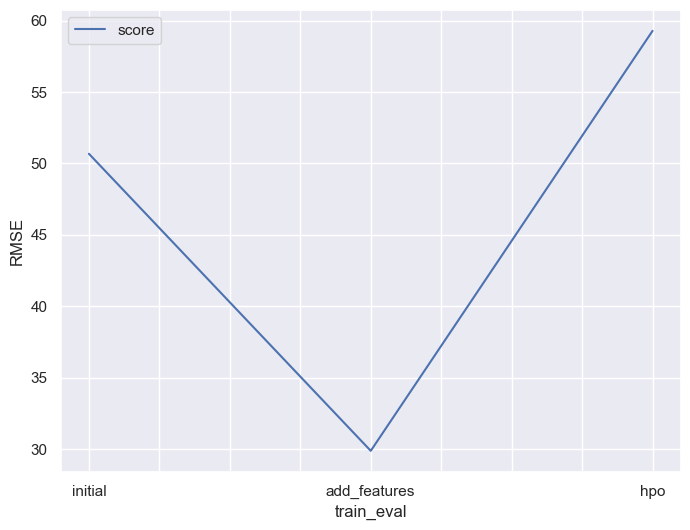

In [121]:
# training scores (best model)
fig = pd.DataFrame(
    {
        "train_eval": ["initial", "add_features", "hpo"],
        "score": [50.672962, 29.878025, 59.280732]
    }
).plot(x="train_eval", y="score", figsize=(8, 6)).get_figure()
plt.ylabel("RMSE")
fig.savefig('../img/model_training_score.png')

Text(0, 0.5, 'Kaggle Score')

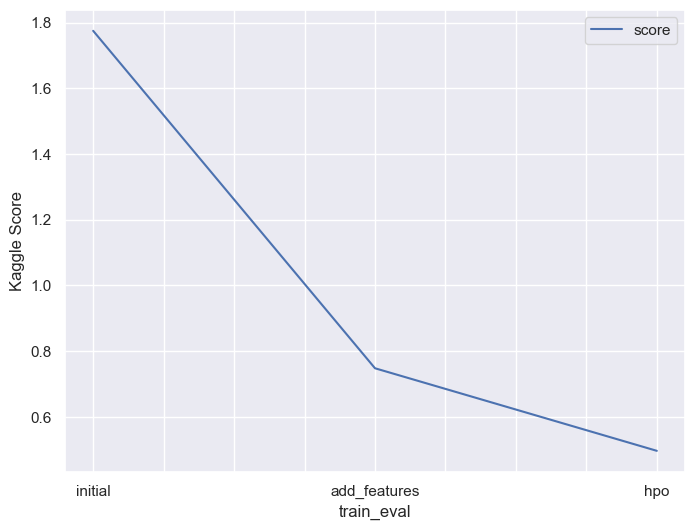

In [119]:
# test scores (best model)
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.77468, 0.74802, 0.4968]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
plt.ylabel("RMSLE")
fig.savefig('../img/model_test_score.png')

In [120]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ['Default settings', 'Default settings', 'NN OPTIONS: {num_epochs: 30, learning_rate: [1e-5, 1e-1], activation: [relu, softrelu, sigmoid, tanh], dropout_prob: [0.0, 0.5]'],
    "hpo2": ['Default settings', 'Default settings', 'GBM options: {num_boost_round: 100, num_leaves: [26,66]}'],
    "hpo3": ['Default settings', 'Default settings', 'Default settings'],
    "score": [1.77468, 0.74802, 0.4968]
})

,model,hpo1,hpo2,hpo3,score
0,initial,Default settings,Default settings,Default settings,1.77468
1,add_features,Default settings,Default settings,Default settings,0.74802
2,hpo,"NN OPTIONS: {num_epochs: 30, learning_rate: [1e-5, 1e-1], activation: [relu, softrelu, sigmoid, tanh], dropout_prob: [0.0, 0.5]","GBM options: {num_boost_round: 100, num_leaves: [26,66]}",Default settings,0.49680
